In [1]:
# Example from NMT Seq2Seq on Tensorflow website
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import re
import io
import unicodedata
from sklearn.model_selection import train_test_split
import time

In [3]:
input_path = '../data/seq2seq/data/words_input.txt'
output_path = '../data/seq2seq/data/words_output.txt'

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [INPUT, OUTPUT]
def create_dataset(input_path, output_path, num_examples):
    lines_i = io.open(input_path, encoding='UTF-8').read().strip().split('\n')
    lines_o = io.open(output_path, encoding='UTF-8').read().strip().split('\n')
    
    print(len(lines_i))
    print(len(lines_o))
    
    assert len(lines_i) == len(lines_o)
    
    total_lines = len(lines_i) if num_examples == None else num_examples
    word_pairs = []
    
    for l in range(0, total_lines):    
        i_w = preprocess_sentence(lines_i[l])
        o_w = preprocess_sentence(lines_o[l])
        
        line_wp = []
        line_wp.append(i_w)
        line_wp.append(o_w)
        
        word_pairs.append(line_wp)
        
    return zip(*word_pairs)

In [7]:
inputs, outputs = create_dataset(input_path, output_path, None)

221426
221426


In [8]:
print(inputs[-1])
print(outputs[-1])

<start> and i assure you , you do not in fact i d be obliged for your best advice . what have your scouts seen ? <end>
<start> so far only their scouts . but we have had reports of a small impi farther north , over there . <end>


In [10]:
#max_vocab_size = 250
max_vocab_size = None

In [11]:
def tokenize(lang, max_vocab=None):
    if max_vocab != None:
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='', num_words=max_vocab)
    else:
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='')        
    
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    
    return tensor, lang_tokenizer

In [14]:
def load_dataset(input_path, output_path, num_examples=None):
    
  # creating cleaned input, output pairs
  inputs, outputs = create_dataset(input_path, output_path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inputs, max_vocab_size)
  target_tensor, targ_lang_tokenizer = tokenize(outputs, max_vocab_size)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
# Try experimenting with the size of that dataset
#num_examples = 30000
num_examples = 1400
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_path, output_path, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

221426
221426


In [16]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1120 1120 280 280


In [17]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
31 ----> not
9 ----> the
972 ----> hacking
17 ----> and
973 ----> gagging
17 ----> and
974 ----> spitting
381 ----> part
1 ----> .
227 ----> please
1 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
84 ----> okay
1 ----> .
1 ----> .
1 ----> .
83 ----> then
60 ----> how
638 ----> bout
19 ----> we
271 ----> try
45 ----> out
102 ----> some
639 ----> french
977 ----> cuisine
1 ----> .
640 ----> saturday
7 ----> ?
272 ----> night
7 ----> ?
3 ----> <end>


In [19]:
BUFFER_SIZE = len(input_tensor_train)
#BATCH_SIZE = 64
#BATCH_SIZE=10
#BATCH_SIZE=10 worked with 1000 samples
BATCH_SIZE = 5
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [20]:
print('Steps per epoch {}'.format(steps_per_epoch))
print('Vocab input size {} Vocab target size {}'.format(vocab_inp_size, vocab_tar_size))

Steps per epoch 224
Vocab input size 2235 Vocab target size 2209


In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([5, 119]), TensorShape([5, 147]))

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (5, 119, 1024)
Encoder Hidden state shape: (batch size, units) (5, 1024)


In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (5, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (5, 119, 1)


In [26]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [27]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (5, 2209)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [29]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = '../models/seq2seq-model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
    
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          
          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [32]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 20 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6287
Epoch 1 Batch 20 Loss 0.5139
Epoch 1 Batch 40 Loss 0.4208
Epoch 1 Batch 60 Loss 0.1862
Epoch 1 Batch 80 Loss 0.3806
Epoch 1 Batch 100 Loss 0.4914
Epoch 1 Batch 120 Loss 0.3710
Epoch 1 Batch 140 Loss 0.2820
Epoch 1 Batch 160 Loss 0.7681
Epoch 1 Batch 180 Loss 0.4344
Epoch 1 Batch 200 Loss 0.4360
Epoch 1 Batch 220 Loss 0.3183
Epoch 1 Loss 0.4984
Time taken for 1 epoch 228.18208742141724 sec

Epoch 2 Batch 0 Loss 0.5336
Epoch 2 Batch 20 Loss 0.4164
Epoch 2 Batch 40 Loss 0.5444
Epoch 2 Batch 60 Loss 0.2747
Epoch 2 Batch 80 Loss 0.3281
Epoch 2 Batch 100 Loss 0.3446
Epoch 2 Batch 120 Loss 0.2106
Epoch 2 Batch 140 Loss 0.4965
Epoch 2 Batch 160 Loss 0.3788
Epoch 2 Batch 180 Loss 0.2005
Epoch 2 Batch 200 Loss 0.4536
Epoch 2 Batch 220 Loss 0.3597
Epoch 2 Loss 0.4368
Time taken for 1 epoch 121.18705725669861 sec

Epoch 3 Batch 0 Loss 0.4173
Epoch 3 Batch 20 Loss 0.2329
Epoch 3 Batch 40 Loss 0.3918
Epoch 3 Batch 60 Loss 0.2171
Epoch 3 Batch 80 Loss 0.6873
Epoch 3 Batch 

In [33]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [34]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [35]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [36]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> remember that time we met up ? <end>
Predicted translation: you re suspended until you . <end> 


/home/mattmann/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/mattmann/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


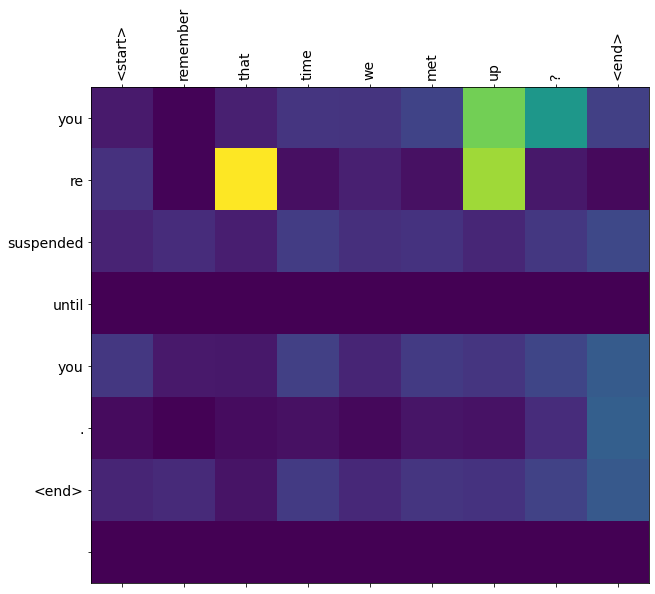

In [40]:
translate(u'Remember that time we met up?')